In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, concatenate
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pylab as pl
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import itertools
import math


# audio lib
import librosa
import librosa.display
from librosa.util import fix_length

import IPython.display as ipd
from PIL import Image


In [2]:
import warnings
warnings.filterwarnings("ignore")

# CNN MEL SPECTROGRAM APPROACH - MERGED DATASET

Una volta capito che il modello migliore era quello ottenuto tramite CNN sono stati generati spettrogrammi di Mel corrispondenti i dataset: "PMEmo", "4Q", "Emotify".
Al fine di ottenere un dataset finale più bilanciato del dataset "PMEmo" sono stati presi solo 600 campioni.

In [3]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [4]:
path1 = '../input/mel-pmemo/melspectrogram_dataset/'
path2 = '../input/mel-4q/melspectrogram_dataset/'
path3 = '../input/mel-emotify/melspectrogram_dataset/'


# Load the images and the labels
imgs = []
dirlist1 = sorted_alphanumeric(os.listdir(path1))
dirlist2 = sorted_alphanumeric(os.listdir(path2))
dirlist3 = sorted_alphanumeric(os.listdir(path3))

count_PMEmo = 0
count_Emotify = 0
for img in dirlist1:
    
    if count_PMEmo < 500:
        pic = image.load_img((path1 + img))
        imgs.append(np.array(pic))
    
    count_PMEmo = count_PMEmo + 1
    
for img in dirlist2:
    pic = image.load_img((path2 + img))
    imgs.append(np.array(pic))
    
for img in dirlist3:
    if count_Emotify < 500:
        pic = image.load_img((path3 + img))
        imgs.append(np.array(pic))
    
    count_Emotify = count_Emotify + 1
    

imgs = np.array(imgs)
imgs.shape

(5111, 300, 300, 3)

In [5]:
df1 = pd.read_csv('../input/mel-pmemo/mel.csv')
df2 = pd.read_csv('../input/mel-4q/mel.csv')
df3 = pd.read_csv('../input/mel-emotify/mel.csv')


df = pd.concat([df1[:500], df2, df3[:500]], ignore_index=True, sort=False)

df

,ID,Label
0,1-0,1
1,1-1,1
2,1-2,1
3,1-3,1
4,1-4,1
...,...,...
5106,2102-0,1
5107,2102-1,1
5108,2102-2,1
5109,2102-3,1


In [6]:
Y = np.array(df['Label'])
Y.shape

(5111,)

[[   0 1116]
 [   1 1348]
 [   2 1091]
 [   3 1556]]


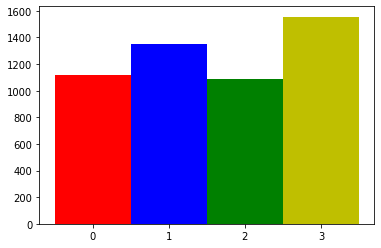

In [7]:
unique, counts = np.unique(Y, return_counts=True)

print(np.asarray((unique, counts)).T)


pos  = np.arange(len(unique))
width = 1.0    
ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(unique)

plt.bar(pos, counts, width, color = ['r','b','g','y'])
plt.show()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(imgs, Y, test_size=0.15, shuffle = True,  random_state=1)

x_train.shape

(4344, 300, 300, 3)

Si effettua uno studio sul learning rate al fine di ottenere il learning rate ottimale per il modello sulla base del dataset utilizzato.

In [9]:
from keras.callbacks import LambdaCallback
import keras.backend as K

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

Si procede a costruire il modello della rete neurale convoluzionale.
si utilizzano i seguenti iperparametri:


*   Tipo di modello: CNN
*   Modello di partenza: EfficientNetB3
*   Numero di epoche 50;
*   Activation Output Layer Softmax: funzione più usata per la classificazione multiclasse;
*   Activation Hidden Layer ReLU: è la funzione di "deafult" grazie alla sua versatilità per la maggior parte degli utilizzi;
*   Loss Function Sparse Categorical Crossentropy: funzione usata nella classificazione multiclasse usando varibili categoriche;
*   Optimizer adam con learning rate ottimale;
*   Regolarizzazione tramite L2 con alpha = 0.1: si limitano le unità con pesi troppo grossi per evitare overfitting e tramite dropout decrescente.
*   Per evitare overfitting si utilizzeranno i pesi che ottengono il miglior valore di accuracy sul validation set.

In [10]:
# Load a pre-trained neural network to use for transfer learning
base_net = keras.applications.EfficientNetB3(
    input_shape=(300,300,3),
    weights='../input/noisystudentkeras/noisystudent_efficientnetb3_notop.h5',
    include_top=False,
    drop_connect_rate=0.5,
    pooling='avg'
)

# Set the layers of the base net to not be trained
for layer in base_net.layers:
  layer.trainable=True

2022-05-26 23:03:18.772323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 23:03:18.902995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 23:03:18.903747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 23:03:18.904936: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
x = Flatten()(base_net.layers[-1].output)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(4, activation='softmax')(x)
outputs = x

OPT = tf.keras.optimizers.Adam()

cnn = keras.Model(inputs=base_net.inputs, outputs=outputs)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

#cnn.summary()

In [12]:
# model is a Keras model
lr_finder = LRFinder(cnn)

# Train a model with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(x_train, y_train, start_lr=0.0001, end_lr=1, batch_size=32, epochs=5)

2022-05-26 23:03:24.611238: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1172880000 exceeds 10% of free system memory.
2022-05-26 23:03:25.941068: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1172880000 exceeds 10% of free system memory.
2022-05-26 23:03:26.840146: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-05-26 23:03:40.520221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


136/136 [==============================] - 120s 736ms/step - loss: 117.0224 - accuracy: 0.3978
Epoch 2/5
136/136 [==============================] - 99s 728ms/step - loss: 4.7307 - accuracy: 0.5536
Epoch 3/5
136/136 [==============================] - 99s 729ms/step - loss: 1.8372 - accuracy: 0.4178
Epoch 4/5
136/136 [==============================] - 84s 615ms/step - loss: 7.0731 - accuracy: 0.2965


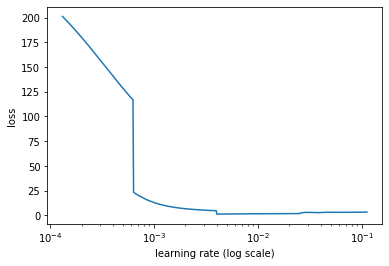

In [13]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

In [14]:
optimal_lr = lr_finder.get_best_lr(sma=1)
print(optimal_lr)
OPT = tf.keras.optimizers.Adam(learning_rate=optimal_lr)

0.00063310104


In [15]:
filepath_cnn="weights.cnn.hdf5"
checkpoint = ModelCheckpoint(filepath_cnn, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [16]:
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])
hist_cnn = cnn.fit(x_train, y_train, batch_size=32, epochs=50, validation_split = 0.15, callbacks=[checkpoint])

2022-05-26 23:11:03.329625: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 996840000 exceeds 10% of free system memory.
2022-05-26 23:11:04.334965: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 996840000 exceeds 10% of free system memory.


Epoch 1/50
116/116 [==============================] - 101s 765ms/step - loss: 48.8760 - accuracy: 0.4615 - val_loss: 3.1509 - val_accuracy: 0.5491

Epoch 00001: val_accuracy improved from -inf to 0.54908, saving model to weights.cnn.hdf5
Epoch 2/50
116/116 [==============================] - 85s 737ms/step - loss: 1.6184 - accuracy: 0.5948 - val_loss: 1.3302 - val_accuracy: 0.5583

Epoch 00002: val_accuracy improved from 0.54908 to 0.55828, saving model to weights.cnn.hdf5
Epoch 3/50
116/116 [==============================] - 86s 738ms/step - loss: 1.0609 - accuracy: 0.6192 - val_loss: 1.1517 - val_accuracy: 0.5675

Epoch 00003: val_accuracy improved from 0.55828 to 0.56748, saving model to weights.cnn.hdf5
Epoch 4/50
116/116 [==============================] - 85s 737ms/step - loss: 0.9721 - accuracy: 0.6495 - val_loss: 1.0020 - val_accuracy: 0.6227

Epoch 00004: val_accuracy improved from 0.56748 to 0.62270, saving model to weights.cnn.hdf5
Epoch 5/50
116/116 [=========================

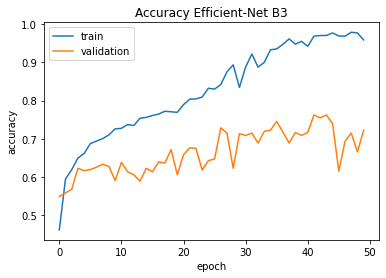

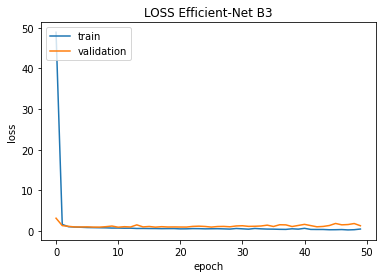

In [17]:
def plot_hist(hist, title):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Accuracy " + title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


plot_hist(hist_cnn, title="Efficient-Net B3")

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Convolutional Neural Network - accuracy: 0.7705345749855042 



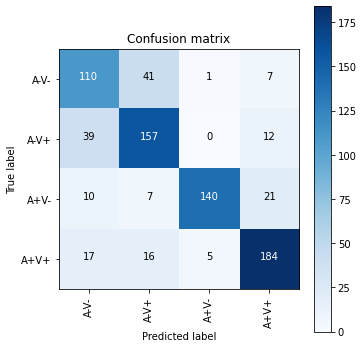

In [19]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Convolutional Neural Network - accuracy:', score[1],"\n")
Y_pred = cnn.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = ['A-V-','A-V+','A+V-','A+V+']) 
plt.show()